In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from scipy.stats import pearsonr
from scipy import stats

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
#import xgboost as xgb
from sklearn.metrics import mean_squared_error

import optuna

from matplotlib.colors import LinearSegmentedColormap

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
np.set_printoptions(linewidth=100)
#torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 100)

In [3]:
#df_train = pd.read_csv('/home/sam/Desktop/train_features.csv')
df_train = pd.read_csv('/home/sam/Desktop/train_features_full.csv')
df_val = pd.read_csv('/home/sam/Desktop/val_features_sen2spring_full.csv')
df_train

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,PopCount
0,-2.258663,1.293138,-2.996038,-0.575559,-2.283529,-0.188085,0.119290,-1.712181,0.589475,4.297632,...,-0.904086,4.048374,1.537473,3.967812,0.724500,-2.137770,0.225233,0.428981,3.685380,1875.0
1,-1.047828,1.884326,-2.331410,-2.225147,0.931954,-0.292078,3.533413,-2.351596,-2.676253,5.435595,...,-3.764316,3.170474,-2.296357,-1.100516,-1.618941,0.029144,-0.384293,0.185415,1.636488,15623.0
2,1.256264,1.287917,-1.623398,-0.807601,-0.191629,-1.443249,0.009767,-2.634470,0.891560,4.414039,...,-1.016576,3.451053,0.256072,-1.164894,-0.288734,-2.942119,-1.182515,0.441435,1.458271,7.0
3,0.275954,0.945337,-1.630023,-2.374230,1.059232,-1.005715,-0.644017,-4.423538,-2.071929,4.296110,...,-3.589805,3.903207,-2.914503,-0.367495,-0.208813,-4.057783,4.047244,0.160762,4.224138,0.0
4,-3.807551,0.863325,-2.075258,-2.690388,2.386226,0.415941,-0.783520,-3.846460,-2.425034,3.960075,...,-0.798793,-2.056659,-2.218732,1.573842,-0.626472,-0.385242,-2.789692,-0.010004,1.100672,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119789,-0.824774,1.542952,1.281719,-4.999974,3.168676,0.668745,-1.308084,-4.155051,1.000480,4.302743,...,-1.625028,1.214373,-0.913813,-3.537408,-0.634347,-1.033690,-2.429408,-0.480590,1.873861,84.0
119790,-1.761228,1.442533,-0.817491,-2.234642,-0.201066,-0.170385,-0.894437,-4.775628,-0.681192,1.449376,...,-2.359940,0.805239,-1.213802,-1.550161,-1.110322,-0.922525,-2.532472,0.485393,-0.392721,340.0
119791,0.436338,1.372671,-1.780801,-3.187654,-0.935278,1.176084,-1.379797,-0.845491,1.186493,0.649688,...,-2.207478,2.019400,-1.127565,-3.842577,-1.937280,-2.486459,-1.381168,-2.777955,0.076584,0.0
119792,-1.662462,1.163252,-0.302995,-3.136119,0.586972,0.439120,-0.788928,-3.858171,-0.338165,0.836020,...,-1.872448,3.181392,-0.101483,-4.183690,-1.696994,-1.138966,-2.282225,-1.565296,0.582951,0.0


In [4]:
df_val

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,PopCount
0,-1.572946,1.701881,-1.744668,-1.730602,-0.458118,-0.480903,0.004936,-2.934512,-0.818544,3.396896,...,-2.807557,6.865187,0.268724,0.229954,-1.476011,-2.797969,-2.243979,0.171131,2.173406,0.0
1,-1.855960,1.814494,-1.576891,-2.437454,-1.194013,-0.278126,-1.129630,-4.145254,-0.585838,3.596437,...,-4.460546,5.878555,0.327318,-1.810410,-0.330138,-3.631624,0.278670,0.159752,2.924775,0.0
2,-1.010746,1.479656,0.344912,-2.146713,0.840336,-0.249672,-1.312627,-6.639433,-0.255110,3.159652,...,-1.023940,3.038432,-0.953151,-0.991137,-0.290495,-2.345687,-2.457734,-1.344143,1.241961,0.0
3,-0.314007,0.807744,-2.964665,-4.845000,1.295797,0.673035,0.651277,-3.669301,-0.247917,4.373765,...,-0.749071,0.456789,-3.813541,-2.663855,-0.790794,-1.335525,-0.750081,-2.740548,2.082489,0.0
4,0.203178,1.803536,-4.787431,1.494698,-0.443997,0.313879,-1.897964,-6.117711,-1.774299,3.977978,...,-1.538388,0.713208,-0.582650,-0.841400,0.669676,-2.107170,-2.063743,-1.968132,2.481665,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18287,-2.106102,2.871209,-2.973956,-0.546221,0.330561,-0.169984,-1.251647,-3.993633,-2.159011,2.619805,...,-2.938044,2.310738,-1.316753,-1.937984,0.250398,-2.847088,-1.065091,-2.278544,6.098589,15762.0
18288,-1.657586,1.100706,0.976617,-3.024606,1.079489,-0.312136,0.126198,-5.031255,0.498281,3.156191,...,-2.585756,1.810582,-2.604308,-1.773614,0.172661,-3.445771,-1.286131,-0.743595,2.813748,5519.0
18289,-0.178578,1.560148,-1.120029,-0.499108,-1.486722,-1.027839,-1.026397,-3.133717,-0.289160,4.442442,...,-2.104027,3.444005,-1.231276,0.265463,-0.312796,-3.531531,-1.670099,0.916649,1.778367,5105.0
18290,2.082999,0.684164,-1.064517,-0.549051,-0.293873,-0.841102,-0.660363,-4.407497,1.301448,3.713321,...,-2.812293,3.040470,-1.032688,-0.272343,-0.036352,-5.344829,0.393127,-0.878283,2.011075,219.0


In [5]:
df_train.isna().sum().sum()

0

In [6]:
df_val.isna().sum().sum()

0

In [7]:
df_train['PopCount']

0          1875.0
1         15623.0
2             7.0
3             0.0
4             0.0
           ...   
119789       84.0
119790      340.0
119791        0.0
119792        0.0
119793     6720.0
Name: PopCount, Length: 119794, dtype: float64

In [8]:
'''
# Delete values in ranges that have to many. Mainly values close to 0
n = 2000  # Number of buckets
x = 400  # Maximum number of values per bucket

# Calculate range and bucket size
value_range = df_train['PopCount'].max() - df_train['PopCount'].min()
bucket_size = value_range / n

bucket_counts = {}

# Populate bucket counts
for index, row in df_train.iterrows():
    bucket_index = int((row['PopCount'] - df_train['PopCount'].min()) / bucket_size)
    if bucket_index not in bucket_counts:
        bucket_counts[bucket_index] = 0
    bucket_counts[bucket_index] += 1

# Create a list of row indices to be deleted
rows_to_delete = []
for index, row in df_train.iterrows():
    bucket_index = int((row['PopCount'] - df_train['PopCount'].min()) / bucket_size)
    if bucket_counts.get(bucket_index, 0) > x:
        rows_to_delete.append(index)
        bucket_counts[bucket_index] -= 1

# Delete rows from the DataFrame
df_filtered = df_train.drop(rows_to_delete)
df_train = df_filtered
'''

"\n# Delete values in ranges that have to many. Mainly values close to 0\nn = 2000  # Number of buckets\nx = 400  # Maximum number of values per bucket\n\n# Calculate range and bucket size\nvalue_range = df_train['PopCount'].max() - df_train['PopCount'].min()\nbucket_size = value_range / n\n\nbucket_counts = {}\n\n# Populate bucket counts\nfor index, row in df_train.iterrows():\n    bucket_index = int((row['PopCount'] - df_train['PopCount'].min()) / bucket_size)\n    if bucket_index not in bucket_counts:\n        bucket_counts[bucket_index] = 0\n    bucket_counts[bucket_index] += 1\n\n# Create a list of row indices to be deleted\nrows_to_delete = []\nfor index, row in df_train.iterrows():\n    bucket_index = int((row['PopCount'] - df_train['PopCount'].min()) / bucket_size)\n    if bucket_counts.get(bucket_index, 0) > x:\n        rows_to_delete.append(index)\n        bucket_counts[bucket_index] -= 1\n\n# Delete rows from the DataFrame\ndf_filtered = df_train.drop(rows_to_delete)\ndf_tra

In [9]:
# df_train = df_train[df_train['PopCount']!=0]
# df_val = df_val[df_val['PopCount']!=0]

/home/sam/anaconda3/envs/nb_env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


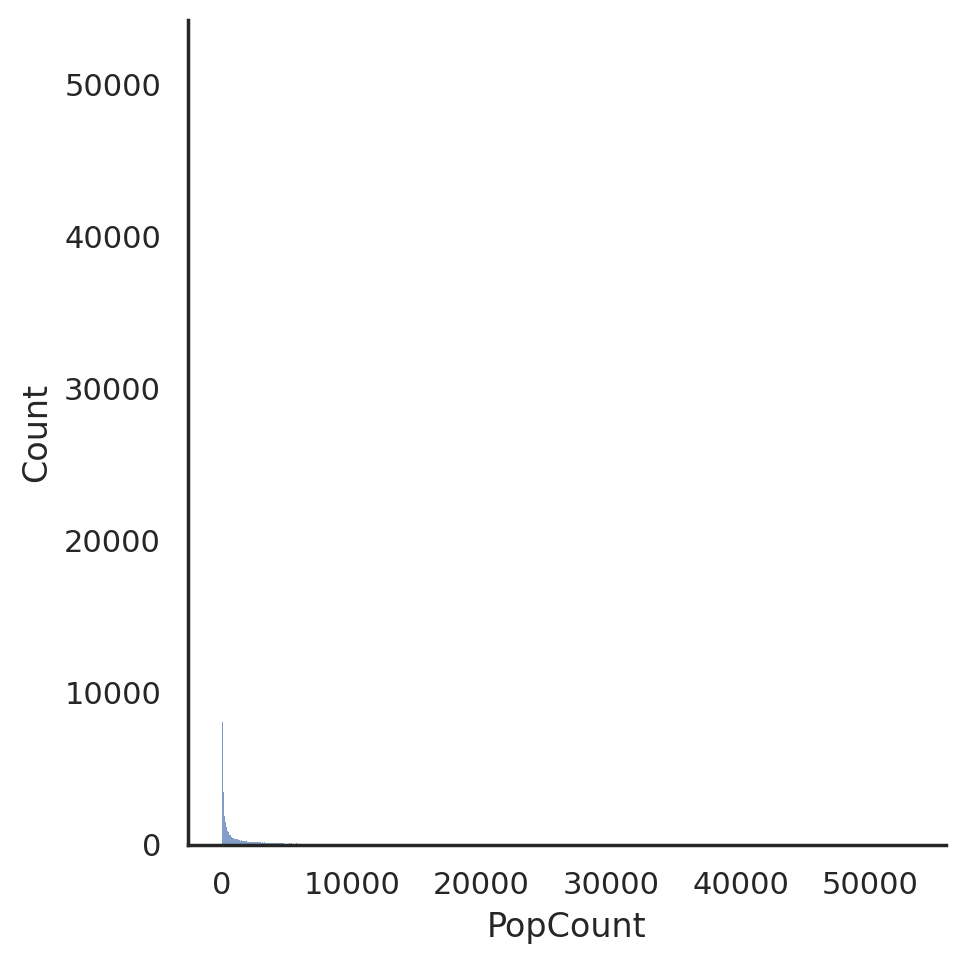

In [10]:
sns.set(style="white")
sns.displot(df_train['PopCount'])
#plt.savefig('/home/sam/Desktop/AI4EO/code/population-estimation/PopHistogram.png', format='png', dpi=200)
#sns.displot(df_train[df_train['PopCount'] > 400]['PopCount'])

/home/sam/anaconda3/envs/nb_env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


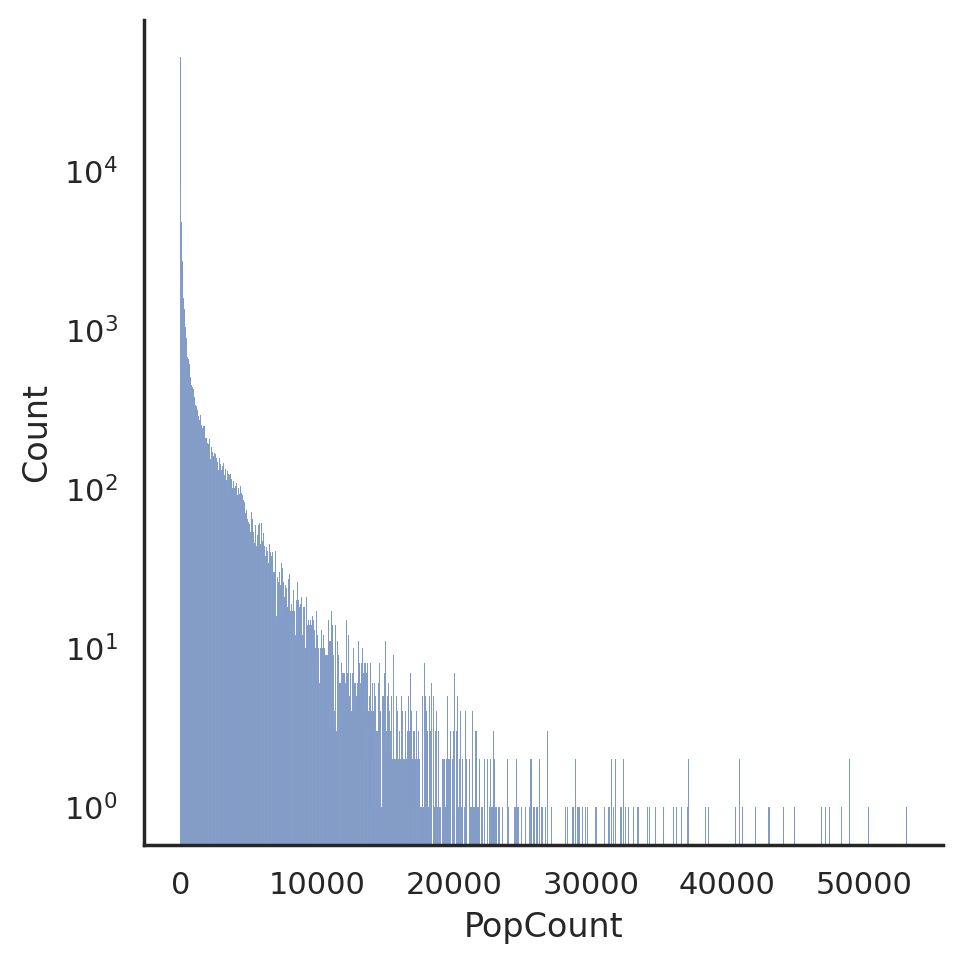

In [11]:
sns.displot(df_train['PopCount'], log_scale=(False, True))
#plt.savefig('/home/sam/Desktop/AI4EO/code/population-estimation/PopHistogramLog.png', format='png', dpi=200)

In [12]:
df_val['PopCount'].describe()

count    18292.000000
mean      1158.546960
std       3141.469928
min          0.000000
25%          0.000000
50%         45.000000
75%        652.250000
max      44636.000000
Name: PopCount, dtype: float64

In [13]:
df_train['PopCount'].describe()

count    119794.000000
mean       1074.556447
std        2715.146382
min           0.000000
25%           0.000000
50%          66.000000
75%         794.000000
max       53119.000000
Name: PopCount, dtype: float64

In [14]:
df_train['PopCount'].skew()

4.961530898862154

In [15]:
df_train['PopCount'].kurt()

38.93009906208681

In [16]:
df_val['PopCount'].skew()

4.503352103719483

In [17]:
df_val['PopCount'].kurt()

28.07821195494406

In [18]:
target = df_train['PopCount']
target_transformed = np.log1p(target)

In [19]:
target_transformed.describe()

count    87617.000000
mean         5.470865
std          2.222327
min          0.693147
25%          3.713572
50%          5.537334
75%          7.334982
max         10.880309
Name: PopCount, dtype: float64

In [20]:
#target_transformed = np.log1p(target / 253.0)

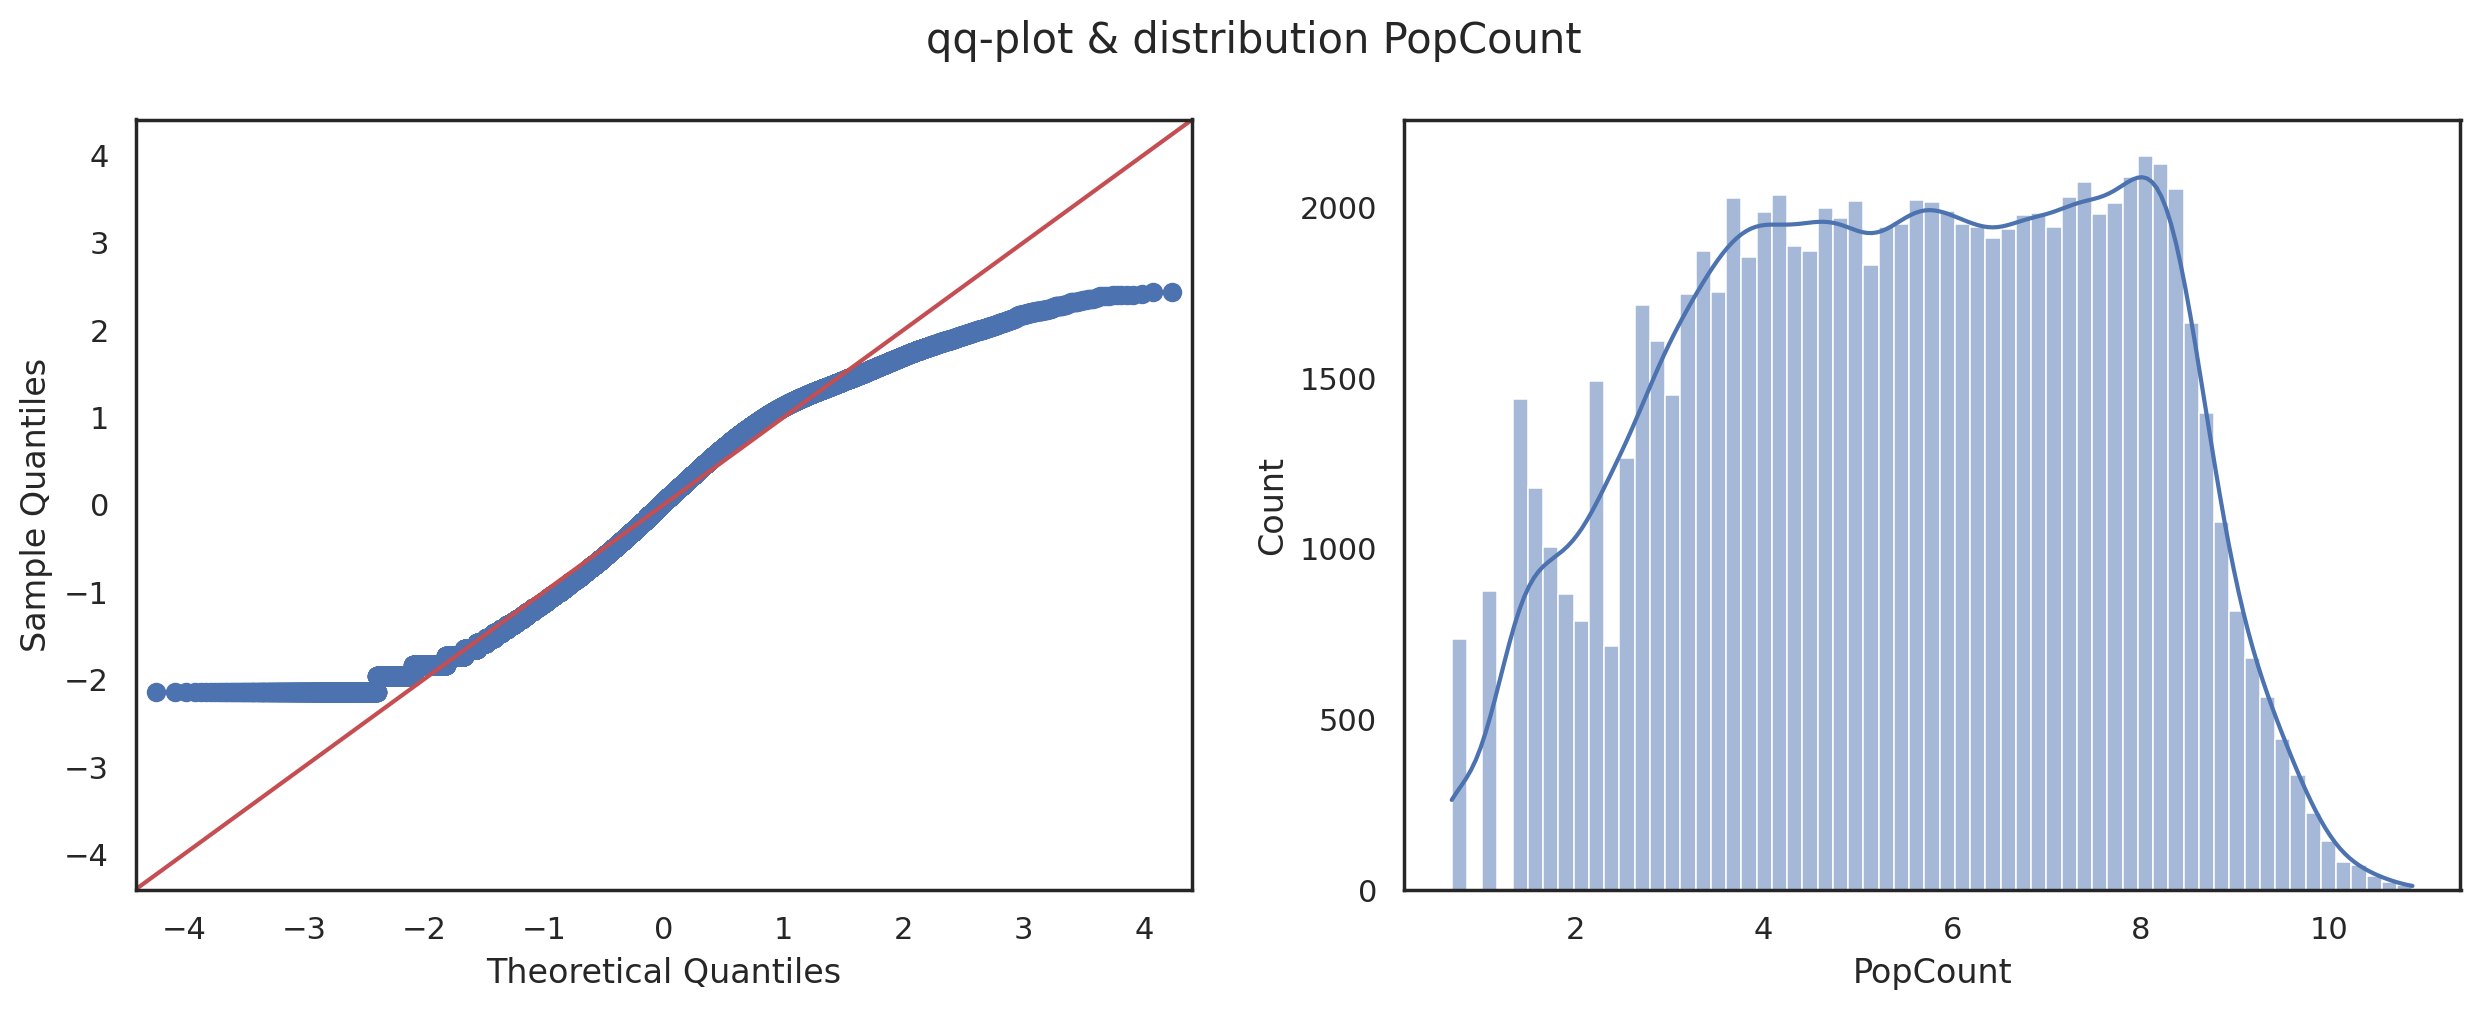

In [21]:
fig, ax = plt.subplots(1, 2, figsize= (15, 5))
fig.suptitle("qq-plot & distribution PopCount ", fontsize=15)

sm.qqplot(target_transformed, stats.t, distargs=(4,),fit=True, line="45", ax=ax[0])
#sm.qqplot(df_train['PopCount'], dist=weibull_dist, fit=False, line="r", ax=ax[0])

sns.histplot(target_transformed, kde=True, ax=ax[1])
#plt.savefig('/home/sam/Desktop/AI4EO/code/population-estimation/qqPopCount.png', format='png', dpi=200)
plt.show()

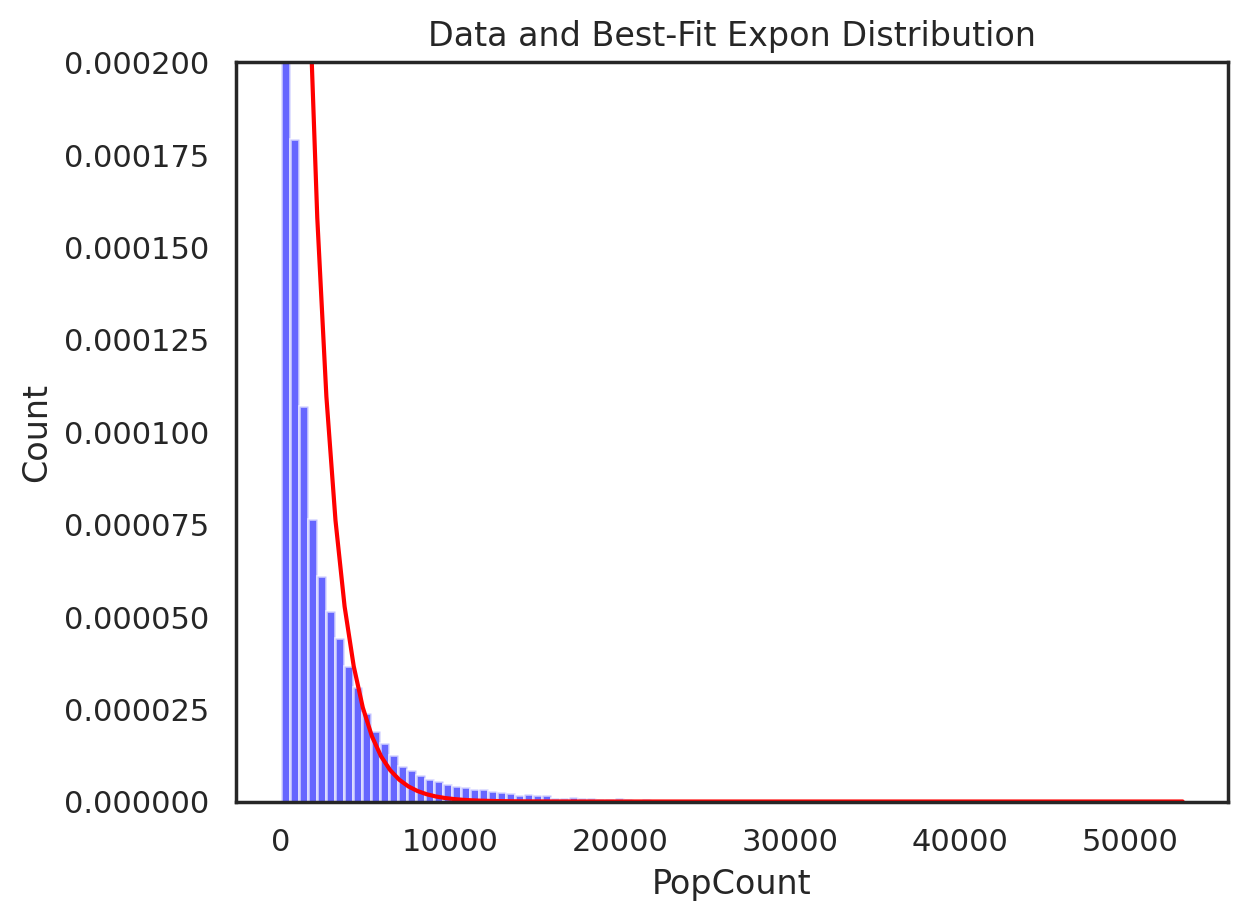

In [22]:
target = df_train['PopCount']
best_fit = stats.expon.fit(target)

# Plot the histogram of data and the best-fit distribution
plt.hist(target, bins=100, density=True, alpha=0.6, color='blue')
x_range = np.linspace(min(target), max(target), 100)
plt.plot(x_range, stats.expon.pdf(x_range, *best_fit), color='red')
plt.xlabel('PopCount')
plt.ylabel('Count')
plt.title('Data and Best-Fit Expon Distribution')
plt.ylim(0, 0.0002)
#plt.savefig('/home/sam/Desktop/AI4EO/code/population-estimation/PopCountFitExp.png', format='png', dpi=200)
plt.show()

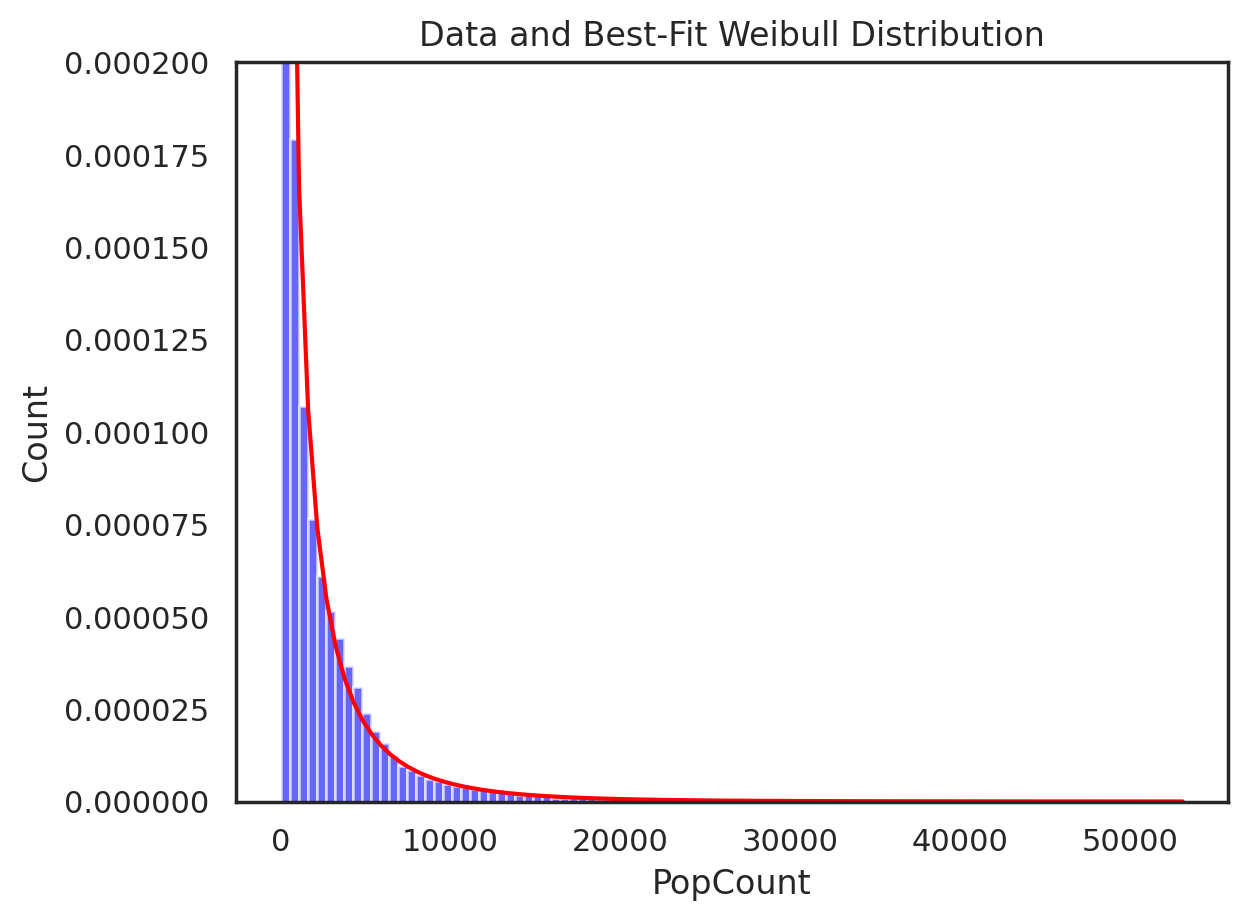

In [23]:
best_fit = stats.exponweib.fit(target)

# Plot the histogram of data and the best-fit Weibull distribution
plt.hist(target, bins=100, density=True, alpha=0.6, color='blue')
x_range = np.linspace(min(target), max(target), 100)
plt.plot(x_range, stats.exponweib.pdf(x_range, *best_fit), color='red')
plt.xlabel('PopCount')
plt.ylabel('Count')
plt.title('Data and Best-Fit Weibull Distribution')
plt.ylim(0, 0.0002)
#plt.savefig('/home/sam/Desktop/AI4EO/code/population-estimation/PopCountFitWeibull.png', format='png', dpi=200)
plt.show()

1. a corresponds to the offset parameter (if applicable).
2. c corresponds to the shape parameter.
3. loc corresponds to the location parameter.
4. scale corresponds to the scale parameter.

In [24]:
print(f'a    : {best_fit[0]}')
print(f'c    : {best_fit[1]}')
print(f'loc  : {best_fit[2]}')
print(f'scale: {best_fit[3]}')
print(best_fit)

a    : 0.7147368232896316
c    : 0.5881668804139415
loc  : 0.9999999999999999
scale: 1258.1695617401892
(0.7147368232896316, 0.5881668804139415, 0.9999999999999999, 1258.1695617401892)


In [25]:
from scipy.integrate import quad
lower_limit = 0
upper_limit = np.inf
def dist(x_range):
    return stats.exponweib.pdf(x_range, *best_fit)
area, error = quad(dist, lower_limit, upper_limit)
print(f'area: {area}   error: {error}')

area: 0.999999999634285   error: 4.291678123991005e-12


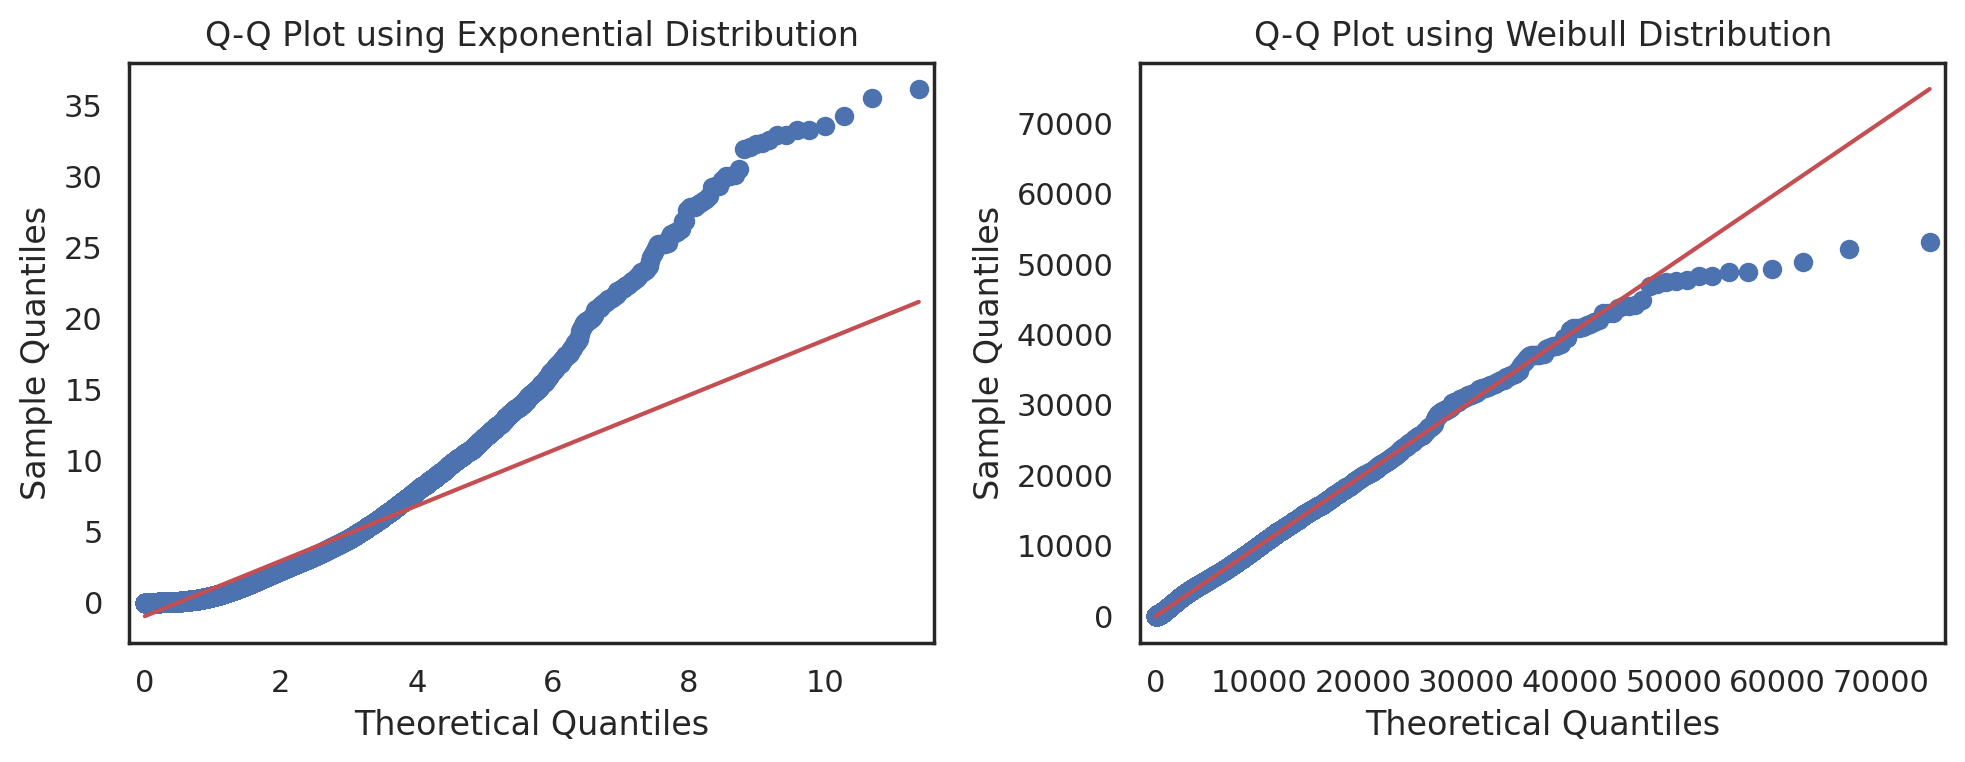

In [26]:
# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Q-Q plot using the Exponential distribution
sm.qqplot(df_train['PopCount'], dist=stats.expon, fit=True, line="r", ax=ax[0])
ax[0].set_title("Q-Q Plot using Exponential Distribution")

# Q-Q plot using the Weibull distribution
#weibull_dist = stats.exponweib(2.4428138246958326, 0.5733831176869839, -1.7650834342453228, 1041.84099564792)
weibull_dist = stats.exponweib(*best_fit)
sm.qqplot(df_train['PopCount'], dist=weibull_dist, fit=False, line="r", ax=ax[1])
ax[1].set_title("Q-Q Plot using Weibull Distribution")

#plt.savefig('/home/sam/Desktop/AI4EO/code/population-estimation/qqPopCountWeibExpWithout0.png', format='png', dpi=200)

plt.tight_layout()
plt.show()

In [28]:
corr = df_train.corr()
#plt.figure(figsize=(20, 10))
#sns.heatmap(corr, cmap='viridis', linewidths=0.5print(plt.colormaps())

In [45]:
print(plt.colormaps())

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'G

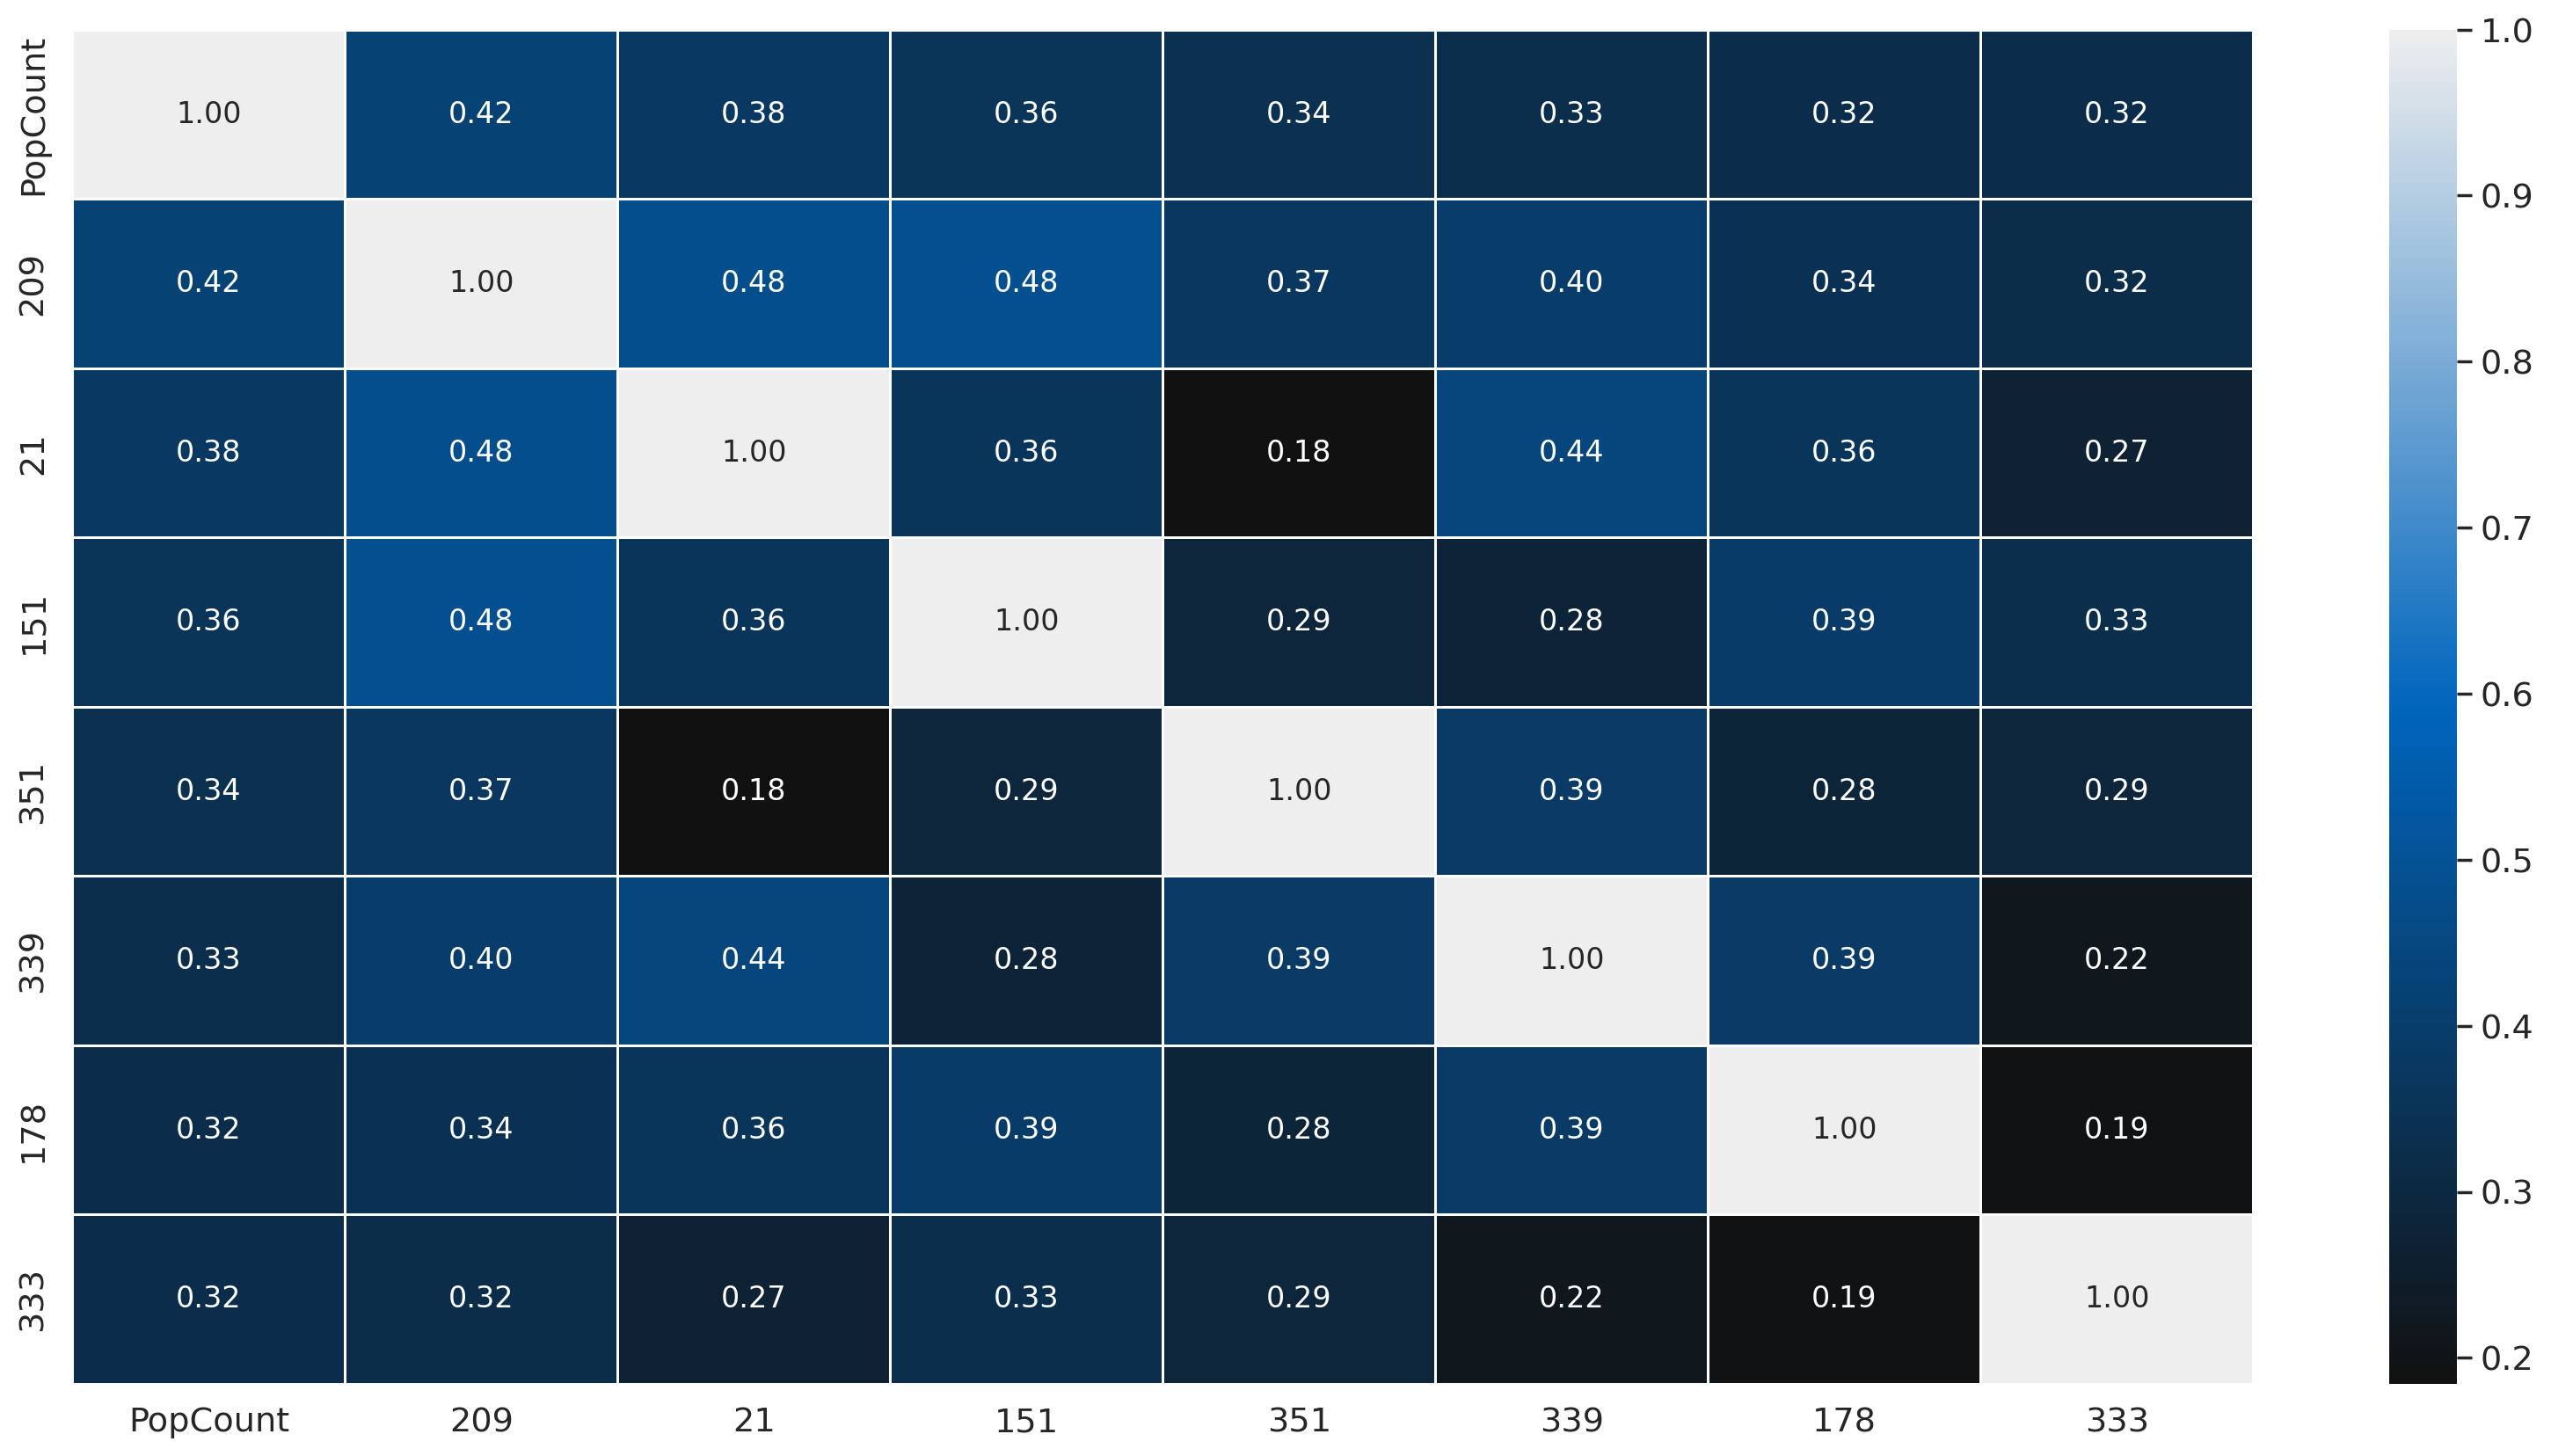

In [91]:
#PopCount correlation matrix
k = 8 #number of variables for heatmap
cols = corr.nlargest(k, 'PopCount')['PopCount'].index
#cols = corr.nsmallest(k, 'PopCount')['PopCount'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(20, 10))

color1 = '#111111'  # Black
color2 = '#0065bd'  # Blue
color3 = '#eeeeee'  # White

# Create the colormap
my_colormap = LinearSegmentedColormap.from_list("my_colormap", [color1, color2, color3])

hm = sns.heatmap(cm, cbar=True, annot=True, cmap=my_colormap,
                 fmt='.2f', annot_kws={'size': 12}, 
                 yticklabels=cols.values, xticklabels=cols.values, linewidths=0.5)
plt.savefig('/home/sam/Desktop/AI4EO/code/population-estimation/CorrFeatureToPopCount.png', format='png', dpi=300)
plt.show()

In [92]:
df_train = df_train[cols]
df_val = df_val[cols]
print(f'df_train: {df_train.shape}   df_val: {df_val.shape}')

df_train: (87617, 8)   df_val: (12527, 8)


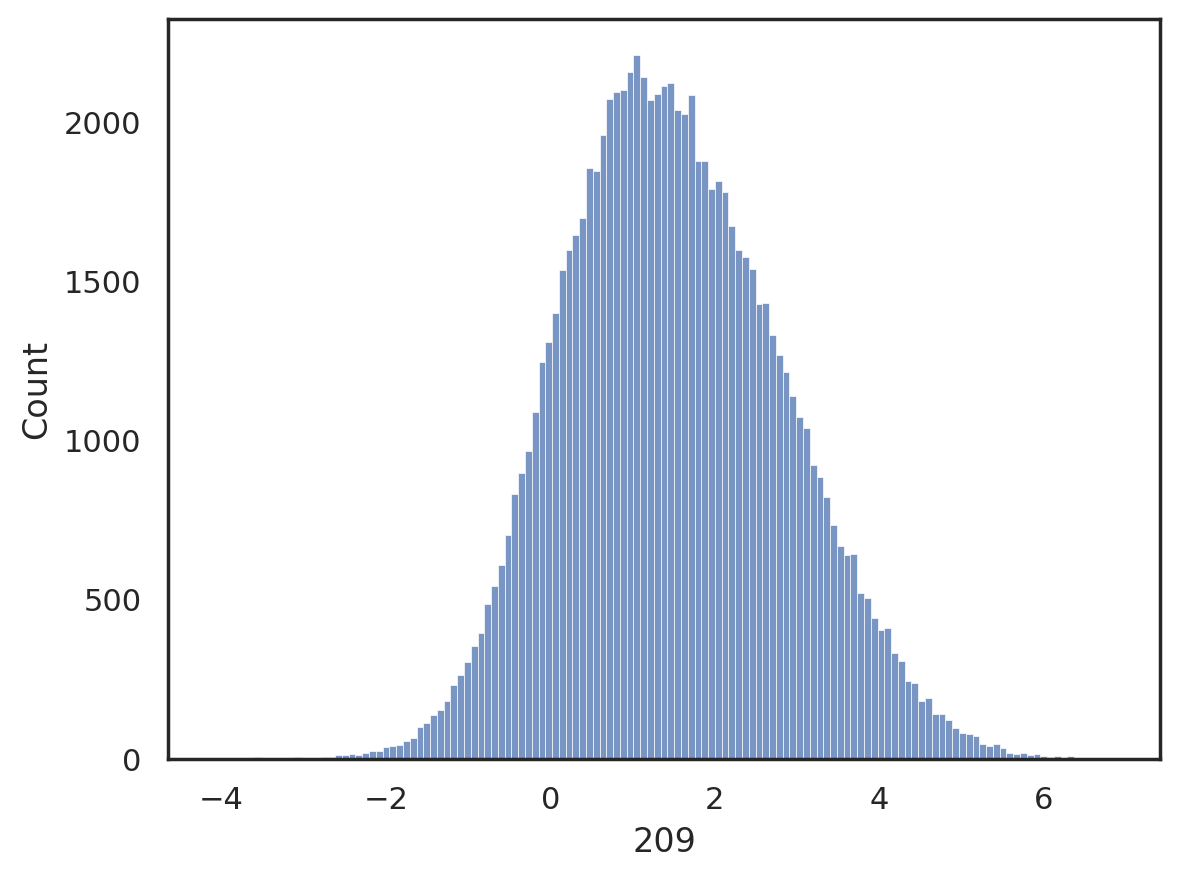

In [93]:
sns.set(style="white")
sns.histplot(df_train['209'])
plt.savefig('/home/sam/Desktop/AI4EO/code/population-estimation/DistSingleFeature.png', format='png', dpi=200)

In [30]:
target = df_train['PopCount']
target_log = np.log1p(target)

ytrain = target
xtrain = df_train.drop('PopCount', axis=1)

#--- val data ---

val_target = df_val['PopCount']
val_target_log = np.log1p(val_target)

yval = val_target
xval = df_val.drop('PopCount', axis=1)

X_train, X_val, y_train, y_val = xtrain, xval, ytrain, yval

#X_train, X_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.1, shuffle=False, random_state=42)
#X_train, y_train = xtrain, ytrain
#X_train

In [ ]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.1, log=True),
        "depth": trial.suggest_int("depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10000),
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [ ]:
params = {'max_leaves': 8,
           'depth': 3,
           'od_wait': 200,
           #'l2_leaf_reg': 3,
          'l2_leaf_reg': 17,
           'iterations': 20,
           #'model_size_reg': 0.7,
          'model_size_reg': 1.7,
           #'learning_rate': 0.05,
          'learning_rate': 0.5,
           'random_seed': 42 }

In [ ]:
model = CatBoostRegressor(**params)

In [ ]:
grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 10, 100, 1000, 10000],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}

In [ ]:
randomized_search_result = model.randomized_search(grid, X=X_train, y=y_train, verbose=False, n_iter=10,)

feature_importance = model.get_feature_importance(prettified=True)
print ('feature_importance', feature_importance)

In [ ]:
model.get_params()

In [ ]:
params = {#'max_leaves': 5,
          'learning_rate': 0.05, 
          'depth': 10, 
          'subsample': 0.5636712389804519, 
          'colsample_bylevel': 0.286574054081783, 
          #'min_data_in_leaf': 2,
          'l2_leaf_reg': 1000,
          'iterations': 2000,
          #'model_size_reg': 0.7,
          'grow_policy': 'Lossguide',
          'random_seed': 42
         }

In [ ]:
params = {'learning_rate': 0.05, 
          'depth': 6, 
          'subsample': 0.1, 
          'colsample_bylevel': 0.95, 
          'min_data_in_leaf': 90,
          'iterations': 3000,
          'l2_leaf_reg': 250}

In [ ]:
model = CatBoostRegressor(**params)

In [ ]:
model.fit(X_train, y_train, 
          eval_set=(X_val, y_val),
          use_best_model=True,
          plot=True,
          verbose=25)

In [ ]:
#final_model.get_all_params()

In [ ]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
final_pred = model.predict(X_val)

In [ ]:
score = rmse(y_val, final_pred)
score

In [ ]:
final_score = rmse(np.exp(y_val), np.exp(final_pred))
final_score

In [ ]:
#df_test = pd.read_csv('/home/sam/Desktop/test_features.csv')
df_test = df_val
#df_test

In [ ]:
df_test['PopCount'].describe()

In [ ]:
test_target = df_test['PopCount']
test_target_log = np.log1p(test_target)

xtest = df_test.drop('PopCount', axis=1)
xtest.shape

In [ ]:
test_pred = model.predict(xtest)
test_pred

In [ ]:
test_score = rmse(np.exp(test_target_log), np.exp(test_pred))
print(test_score)
test_score = rmse((test_target_log), (test_pred))
print(test_score)

In [ ]:
pd.set_option('display.max_rows', 15)  # Set to None for more rows
pd.set_option('display.max_columns', 15)  # Set to None for more columns

print(np.exp(test_pred))
print(np.exp(test_target_log))

In [ ]:
print(np.exp(test_pred))
print(np.exp(test_target_log))